<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/ExtracellularSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2018.1.0


#Load pre-defined functions

In [3]:
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py

from DmriFemBuitInFunc import *

class MRI_parameters():
    def __init__(self):
        # Initialize default parameters
        self.bvalue = None
        self.qvalue = None        
        self.gdir = [1, 0, 0];
        self.stype='PGSE'
        self.nperiod = 0; # number of period for OGSE sequences
    def set_gradient_dir(self, mymesh, g0, g1, g2):
        gdim = mymesh.geometry().dim()
        if gdim==2:
            self.gdir = Point(g0, g1)
            self.gdir /= self.gdir.norm()
            self.g = Expression(("g0","g1"), g0=self.gdir.x(), g1=self.gdir.y(),domain=mymesh, degree=1);
        if gdim==3:
            self.gdir = Point(g0, g1, g2)
            self.gdir /= self.gdir.norm()        
            self.g = Expression(("g0","g1","g2"), g0=self.gdir.x(), g1=self.gdir.y(), g2=self.gdir.z(),domain=mymesh, degree=1);
    def time_profile(self, t):
        ft1, ft2 = 0, 0;
        if self.stype=='PGSE':
            ft1 = 1.0*(t>=0 and t<self.delta) 
            ft2 = -1.0*(t>=self.Delta and t<=self.Delta+self.delta);
        if self.stype=='cos_OGSE':
            ft1 =  cos(2.0*self.nperiod*pi*t/self.delta)*(t>=0 and t<self.delta);
            ft2 = -cos(2.0*self.nperiod*pi*(t-2.*self.delta)/self.delta)*(t>=Delta and t<=self.Delta+self.delta);
        return ft1 + ft2; 
    def itime_profile(self, t): 
        # integrate ft
        ft1, ft2, ft3 = 0, 0, 0;
        if self.stype=='PGSE':
            ft1 = t*(t>=0 and t<self.delta) 
            ft2 = self.delta*(t>=self.delta and t<self.Delta) 
            ft3 = (self.delta - t + self.Delta)*(t>=self.Delta and t<=self.Delta+self.delta) 
        if self.stype=='cos_OGSE':
 	          ft1 = 1.0/2.0*self.delta*sin(2.0*t*self.nperiod*pi/self.delta)/self.nperiod/pi * (t >= 0 and  t <= self.delta)
 	          ft2 = 1.0/2.0*self.delta*(sin(2.0*self.Delta*self.nperiod*pi/self.delta)-sin(2.0*t*self.nperiod*pi/self.delta))/nperiod/pi *(t>=self.Delta and t<=self.Delta+self.delta)
        return ft1 + ft2 + ft3;  
    def convert_b2g(self):
        self.gnorm = 0;
        if (self.stype == 'PGSE'):
            self.gnorm = sqrt(self.bvalue)/sqrt(self.delta*self.delta*(self.Delta-self.delta/3.0));
        if (self.stype == 'cos_OGSE'):
            self.gnorm = sqrt(self.bvalue/(1./8.*self.delta*self.delta*self.delta*(3.-cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi)));
        if (self.stype == 'sin_OGSE'):
            self.gnorm = sqrt(self.bvalue/(1./8.*self.delta*self.delta*self.delta*(5.+cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi)));
        return self.gnorm
    def convert_g2b(self):
        self.bvalue = 0;
        if (self.stype == 'PGSE'):
            self.bvalue = self.gnorm*self.gnorm*self.delta*self.delta*(self.Delta-self.delta/3.0);
        if (self.stype == 'cos_OGSE'):
            self.bvalue=self.gnorm*self.gnorm*1./8.*self.delta*self.delta*self.delta*(3.-cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi);
        if (self.stype == 'sin_OGSE'):
	          self.bvalue=self.gnorm*self.gnorm*1./8.*self.delta*self.delta*self.delta*(5.+cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi);
        return self.bvalue
      
    def Apply(self):
        self.T = self.Delta+self.delta;
        if not(self.bvalue==None):
            self.gnorm = self.convert_b2g();
            self.qvalue = convert_g2q(self.gnorm);
        elif not(self.qvalue==None):
            self.gnorm = convert_q2g(self.qvalue);
            self.bvalue = self.convert_g2b();
        elif (self.bvalue==None and self.bvalue==None):
            print("bvalue or qvalue need to be specified.")
            sys.exit()      
          
class MRI_simulation():
    def __init__(self):
          self.nskip = 5;    # Output frequency (for visualization only)
          self.theta = 0.5;  # theta=0.5: midpoint method

    def InitialCondition(self, mydomain):
          if mydomain.gdim==2:
              Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e6, domain=mydomain.mymesh, degree=1);
          if mydomain.gdim==3:
              Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]+x[2]*x[2]<eps",eps=1e6, domain=mydomain.mymesh, degree=1);
          Dirac_Delta = interpolate(Dirac_Delta, mydomain.V);
          u_0 = Function(mydomain.W);
          assign(u_0.sub(0), Dirac_Delta)
          if (mydomain.IsDomainMultiple==True):
              assign(u_0.sub(2), Dirac_Delta)  
          return Dirac_Delta, u_0
        
    def solve(self, mydomain, mri_para, linsolver): 
      
          self.Dirac_Delta, self.u_0 = self.InitialCondition(mydomain)
          
          stepcounter = 0;

          M = MassMatrix(mydomain);

          self.t = 0;
          ft_prev  =  mri_para.time_profile(self.t);
          ift_prev = mri_para.itime_profile(self.t);

          start_time = time.time()
          
          while self.t < mri_para.T + self.k: # Time-stepping loop
              if stepcounter % self.nskip == 0:
                  print('t: %6.2f '%self.t, 'T: %6.2f'%mri_para.T, 'dt: %.1f'%self.k,'gnorm: %e'%mri_para.gnorm,'Completed %3.2f%%'%(float(self.t)/float(mri_para.T+mri_simu.k)*100.0));

              ft = mri_para.time_profile(self.t);
              ift = mri_para.itime_profile(self.t);
              L = ThetaMethodL(ft_prev, ift_prev, mri_para, self, mydomain);
              A = 1/self.k*M + assemble(ThetaMethodF(ft, ift, mri_para, self, mydomain))

              b = assemble(L);
              
              linsolver.solve(A, self.u_0.vector(),b);

              ft_prev  = ft;
              ift_prev = ift;

              self.t += self.k;
              stepcounter += 1;

          elapsed_time = time.time() - start_time
          print("Successfully Completed! Elapsed time: %f seconds"%elapsed_time)

Load pre-defined functions from GitHub


# Working on the mesh

In [9]:
!rm -rf *

file_name='2E_ExtraCellular_group_vol'
file_dir='https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/'+file_name+'.msh.zip'

!wget -q $file_dir
!unzip -q $file_name''.msh.zip
!dolfin-convert $file_name''.msh $file_name''.xml
!sed -i 's/dim="2"/dim="3"/g' $file_name''.xml

mymesh = Mesh(neuron_name+'.xml');
gdim = mymesh.geometry().dim()
tdim = mymesh.topology().dim()

print('Topological dimension: ',tdim)
print('Geometrical dimension: ',gdim)
print('Mesh size: #vertices: '+str(mymesh.num_vertices()) +', #elements: '+str(mymesh.num_cells()) );

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 190818 vertices
Found all vertices
Expecting 773149 cells
Found all cells
Conversion done
Topological dimension:  3
Geometrical dimension:  3
Mesh size: #vertices: 190818, #elements: 773149


# Solve the Bloch-Torrey equation

In [11]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

#################################################################################
#########################  Pre-defined parameters ###############################
mri_para.stype='PGSE'                                # sequence type
mri_para.bvalue = 1000;                              # bvalue
mri_para.delta, mri_para.Delta = 10000, 10000        # time sequence
mri_para.set_gradient_dir(mymesh, 0, 1, 0)           # gradient direction
mri_para.Apply()
mri_simu.k = 500;                                    # time-step size
mri_simu.nskip = 1;                                  # frequency to print ouputs
mydomain = MyDomain(mymesh, mri_para)
mydomain.phase = None
mydomain.PeriodicDir = [0, 0, 0];             # Direction of the periodicity
mydomain.IsDomainPeriodic = False             # Confirm if the mesh if periodic
mydomain.IsDomainMultiple = False             # Confirm if the mesh is multiple
mydomain.kappa = 1e-5                         # Permeability
################################################################################
mydomain.Apply()   # Call Apply before setting the diffusion tensor
################################################################################
# Impose the diffusion coefficient
D0 = 3e-3
mydomain.D = D0;
#################################################################################

mri_simu.solve(mydomain, mri_para, PETScLUSolver("mumps"))

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize a standard function space.
t:   0.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 0.00%
t: 500.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 2.44%
t: 1000.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 4.88%
t: 1500.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 7.32%
t: 2000.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 9.76%
t: 2500.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 12.20%
t: 3000.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 14.63%
t: 3500.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 17.07%
t: 4000.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 19.51%
t: 4500.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 21.95%
t: 5000.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 24.39%
t: 5500.00  T: 20000.00 dt: 500.0 gnorm: 3.872983e-05 Completed 26.83%
t: 6000.00  T: 20000.00 dt: 500.0 gn

#Post-processing

b: 1000 Signal: 9.018e-01 , dt:  500 , hmin:  0.00042734878258709243 , Free signal: 4.979e-02


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


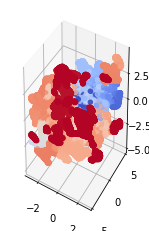

In [12]:
if mydomain.IsDomainMultiple == True:
    u0r_0, u0i_0, u1r_0, u1i_0 = split(mri_simu.u_0)
    signal0 = assemble(((1-mydomain.phase)*u0r_0)*dx)/assemble((1-mydomain.phase)*mri_simu.Dirac_Delta*dx);
    signal1 = assemble((mydomain.phase*u1r_0)*dx)/assemble(mydomain.phase*mri_simu.Dirac_Delta*dx);
    signal = assemble((mydomain.phase*u1r_0+(1-mydomain.phase)*u0r_0)*dx)/assemble(mri_simu.Dirac_Delta*dx);
    print('Signal on each compartment')
    print('Signal0: %.3e'%signal0)
    print('Signal1: %.3e'%signal1)
    print('b:',mri_para.bvalue, 'Signal: %.3e'%signal,'kappa: %.3e'%mydomain.kappa,', dt: ',mri_simu.k,', hmin: ',mydomain.hmin, ', Free signal: %.3e'%(exp(-mri_para.bvalue*D0)))
    V0 = FunctionSpace(mesh0, mydomain.Ve);
    V1 = FunctionSpace(mesh1, mydomain.Ve);
    u0r_0p = project(u0r_0,V0)
    u1r_0p = project(u1r_0,V1)
    plot(u0r_0p, cmap="coolwarm")
    plot(u1r_0p, cmap="coolwarm")  
else:
    ur, ui = split(mri_simu.u_0)
    signal = assemble(ur*dx)/assemble(mri_simu.Dirac_Delta*dx);
    print('b:',mri_para.bvalue, 'Signal: %.3e'%signal,', dt: ',mri_simu.k,', hmin: ',mydomain.hmin, ', Free signal: %.3e'%(exp(-mri_para.bvalue*D0)))
    V = FunctionSpace(mymesh,mydomain.Ve);
    ur_p = project(ur,V)
    plot(ur_p, cmap="coolwarm")